In [1]:
########## MODIFIED plaidml code.
##### in file /usr/local/lib/python3.6/site-packages/plaidml/keras/backend.py
##### 2097: changed outshine = x.shape[:2] + num_out_size
#####            to outshine = list(x.shape[:2]) + num_out_size





from itertools import product

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image, ImageOps

# Linear dimensionality reduction: Linear PCA
from sklearn.decomposition import PCA

# Non-linear dimensionality reduction: Kernel PCA
from sklearn.decomposition import KernelPCA

# DAISY feature extraction
from skimage.feature import daisy

# Pairwise distances for feature visualization
from sklearn.metrics.pairwise import pairwise_distances

matplotlib.rcParams.update({'figure.figsize': (15, 9)})
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'axes.labelsize': 20})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
matplotlib.rcParams.update({'font.family': 'Helvetica, Arial, sans-serif'})
%config InlineBackend.figure_format = 'retina'

sns.set_style("whitegrid")

In [2]:
image_size = (16, 16)

In [3]:
%%time

# the directory immediately under which all the images
# reside.
file_prefix = 'data/'

# The PIL flag for grayscale.
GRAYSCALE_MODE = 'L'

# Will store tuples (id,image_data,is_dog) and then
# will be converted into the DataFrame `images`.
images_list = []

# load data/cat.0.jpg to data/cat.4999.jpg, 
# then data/dog.0.jpg to data/dog.4999.jpg.
for pet_type, index in product(['cat', 'dog'], range(5000)):
    file_name = f'{pet_type}.{index}'
    
    # Load and convert to grayscale
    image = Image.open(f'{file_prefix}{file_name}.jpg').convert(mode=GRAYSCALE_MODE)
    
    # Aspect fit the image (shrink the image while maintaining
    # the aspect ratio such that the shorter dimension matches its target value
    # in image_size above. Then center it and crop off the excess to fit in
    # the dimensions of image_size).
    image = ImageOps.fit(image, image_size, method=Image.ANTIALIAS)
    
    # The PIL.ImageData object is essentially a matrix. Linearize it as a numpy array.
    data = np.asarray(image.getdata())/255
    
    # Add the boolean field `is_dog` as a simple representation of our cat/dog dichotomy.
    is_dog = (pet_type == 'dog')
    images_list.append((file_name,data,is_dog))

images = pd.DataFrame(data=images_list,columns=['id','image_data','is_dog'])

CPU times: user 1min 13s, sys: 2.89 s, total: 1min 15s
Wall time: 1min 21s


In [4]:
images.head()

,id,image_data,is_dog
0,cat.0,"[0.803921568627, 0.847058823529, 0.74117647058...",False
1,cat.1,"[0.188235294118, 0.176470588235, 0.18823529411...",False
2,cat.2,"[0.792156862745, 0.678431372549, 0.53725490196...",False
3,cat.3,"[0.650980392157, 0.541176470588, 0.49803921568...",False
4,cat.4,"[0.725490196078, 0.760784313725, 0.77254901960...",False


In [5]:
old_memory_usage = images.memory_usage(deep=True).sum()
# images.image_data = images.image_data.apply(lambda data: data.astype('uint8'))
# new_memory_usage = images.memory_usage(deep=True).sum()
print('Old size:',old_memory_usage/1000000.,'MB')
# print('New size:',new_memory_usage/1000000.,'MB')
# print('Savings of', 100.0*(old_memory_usage-new_memory_usage)/old_memory_usage, 'percent!')

Old size: 22.17786 MB


In [6]:
### SPLIT TRAIN TEST DATA
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images['image_data'], images['is_dog'], test_size=.2)
print('X_train shape', X_train.shape)
print('X_test shape', X_test.shape)
print('y_train shape', y_train.shape)
print('y_test shape', y_test.shape)

X_train shape (8000,)
X_test shape (2000,)
y_train shape (8000,)
y_test shape (2000,)


In [7]:
# [CITE] "04. Dimension Reduction and Images Notebook" by Eric Larson

def plot_gallery(imgs, titles, size, rows=3, cols=6):
    plt.figure(figsize = (1.7 * cols, 2.3 * rows))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    
    for i in range(rows * cols):
        plt.subplot(rows, cols, i+1)
        ax = plt.gca()
        [spine.set_color('black') for _,spine in ax.spines.items()]
        plt.imshow(imgs[i].reshape(size), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks([]); plt.yticks([])
    plt.show()

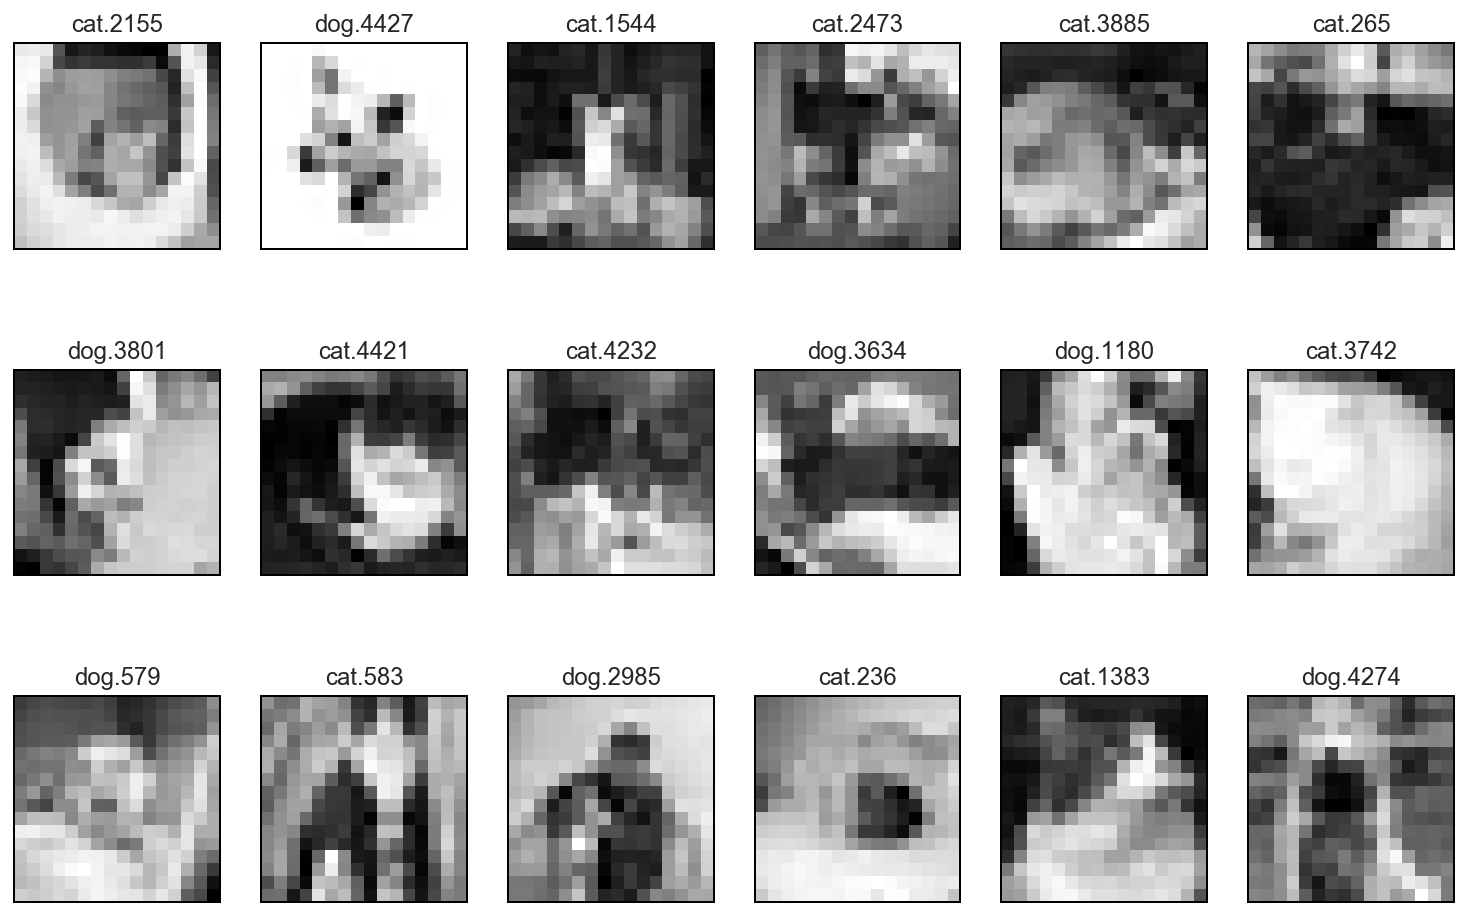

In [8]:
some_images = images.sample(n=18)
plot_gallery(some_images.image_data.iloc, some_images.id.iloc, image_size)

In [9]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import Callback


class ConvolutionalNeuralNet:
    def __init__(
         self,
         input_shape=(64,64),
         filters_per_clayer=[32,64,16], 
         kernel_size=[(5,5),(3,3),(3,3)], 
         pool_size=(2,2),
         size_per_dlayer=[1024,128,16],
         size_final_dlayer=2,
         convolution_dropout_rate=.25,
         dense_dropout_rate=.5,
         convolution_activation='relu',
         dense_activation='relu',
         final_activation='softmax',
        
         loss='mean_squared_error', 
         optimizer='rmsprop', 
         metrics=['binary_accuracy'],
        
         batch_size=32,
         epochs=100,
         shuffle=True,
         verbose=0
    ):
        self.input_shape = input_shape;
        self.filters_per_clayer = filters_per_clayer
        self.kernel_size = kernel_size
        self.pool_size = pool_size
        self.size_per_dlayer = size_per_dlayer
        self.size_final_dlayer = size_final_dlayer
        self.convolution_dropout_rate = convolution_dropout_rate
        self.dense_dropout_rate = dense_dropout_rate
        self.convolution_activation = convolution_activation
        self.dense_activation = dense_activation
        self.final_activation = final_activation
        
        self.loss = loss
        self.optimizer = optimizer
        self.metrics = metrics
        
        self.batch_size = batch_size
        self.epochs = epochs
        self.shuffle = shuffle
        self.verbose = verbose
        
        self._make_model()
    
    def _make_convolution_layers(self):
            
        if(len(self.filters_per_clayer) != len(self.kernel_size)):
            raise ValueError('The number of filters must equal the number of kernal sizes')
            
        self._model.add(Reshape((1,self.input_shape[0],self.input_shape[1]), 
                       input_shape=(1,self.input_shape[0]*self.input_shape[1])))
                       
        for i in range(len(self.filters_per_clayer)):
            if(
                int(self.input_shape[0]/(self.pool_size[0]*(i+1))) == 0 
            or 
                int(self.input_shape[1]/(self.pool_size[1]*(i+1))) == 0
            ):
                print("Warning: Size zero layer defined with input_shape (1,0,0). Reduce layer count")
                
            
            self._model.add(
                Conv2D(
                    filters=self.filters_per_clayer[i],
                    kernel_size=self.kernel_size[i],
                    padding='same',
                    activation=self.convolution_activation
                )
            )
            self._model.add(MaxPooling2D(pool_size=self.pool_size, data_format='channels_first'))
        
        self._model.add(Dropout(self.convolution_dropout_rate))
        self._model.add(Flatten())
                
    def _make_dense_layers(self):
        for size in self.size_per_dlayer:
            self._model.add(Dense(size, activation=self.dense_activation))
        self._model.add(Dropout(self.dense_dropout_rate))
        self._model.add(Dense(self.size_final_dlayer, activation=self.final_activation))
                
    def _make_model(self):
        self._model = Sequential()
        self._make_convolution_layers()
        self._make_dense_layers()
                
        self._model.compile(loss=self.loss,
                           optimizer=self.optimizer,
                           metrics=self.metrics)
                
    def fit(self, X, y_ohe):
        # Using keras Callbacks to hook into end of epoch
        # for per-epoch evaluation statistics collection
        # [CITE] https://github.com/fchollet/keras/issues/2548#issuecomment-215664770
        self.epoch_log_ = []
        net = self
        class AnalyticsCallback(Callback):
            def on_epoch_end(self, epoch, logs={}):
                net.epoch_log_.append(logs)
        X = np.matrix(X.tolist())
        X = np.expand_dims(X, axis=1)
        self._model.fit(X, y_ohe, 
                       batch_size=self.batch_size,
                       epochs=self.epochs,
                       shuffle=self.shuffle,
                       verbose=self.verbose,
                       callbacks=[AnalyticsCallback()])
                       
    def predict(self,X):
        X = np.matrix(X.tolist())
        X = np.expand_dims(X, axis=1)
        return self._model.predict(X)
    
    @staticmethod
    def one_hot_output(y_hat_raw):
        # predict() outputs floats. We want one-hot in most cases
        y_hat = np.zeros(y_hat_raw.shape, dtype=np.int)
        y_hat[np.arange(y_hat_raw.shape[0]), y_hat_raw.argmax(1)] = 1
        return y_hat

Using TensorFlow backend.


In [10]:
# we store the networks in this array
# so we can grab their epoch_log_ properties
# wherein we persist the per-epoch accuracy
# so we can make pretty charts.
def cross_validation_step(ModelClass, indices, parameters): 
    train_index, test_index = indices
    X_train = data.iloc[train_index]
    y_train = np.asarray(pd.get_dummies(target.iloc[train_index]))
    X_test = data.iloc[test_index]
    y_test = target.iloc[test_index]
    
    # training
    clf = ModelClass(**parameters)
    clf.fit(X_train, y_train)
    
    # testing
    y_hat_raw = clf.predict(X_test)
    y_hat = ConvolutionalNeuralNet.one_hot_output(y_hat_raw)
    score = evaluation_function(pd.get_dummies(y_test), y_hat)
    return score,clf

def cross_validation(ModelClass, cv, parameters):
    cv_indices = cv.split(data, target)
    scores = np.empty(n_splits)
    nets = [None]*n_splits
    
    if 'epochs' in parameters:
        total_epochs = n_splits*parameters['epochs']
        print(
            f'Performing {n_splits}-fold Stratified cross validation with {parameters["epochs"]} '
            f'epochs each ({total_epochs} epochs total)'
        )
        if total_epochs > 80:
            print('☕️ you may want to grab a coffee')
        
    # I promise I tried parallelizing this 
    # but Tensorflow didn't like it.
    #
    # (tried threading.Thread and multiprocess.Pool)
    for i,indices in enumerate(cv_indices):
        print(f'Split {i+1} of {n_splits} {"☕️"*(i+1)}')
        scores[i],nets[i] = cross_validation_step(ModelClass, indices, parameters)
        
    return scores,nets

def get_logs_from_nets(nets, parameter_name):
    return [[epoch[parameter_name] for epoch in net.epoch_log_] for net in nets]

In [11]:
from sklearn.metrics import roc_auc_score
evaluation_function = roc_auc_score

from sklearn.model_selection import StratifiedKFold

n_splits = 10
cv = StratifiedKFold(n_splits=n_splits, random_state=None, shuffle=False)


params = dict(
        input_shape=image_size,
        filters_per_clayer=[64,64,16], 
        kernel_size=[(5,5),(3,3),(3,3)], 
        pool_size=(2,2),
        size_per_dlayer=[512,16],
        size_final_dlayer=2,
        convolution_dropout_rate=.35,
        dense_dropout_rate=.65,
        convolution_activation='relu',
        dense_activation='relu',
        final_activation='softmax',
        
        loss='mean_squared_error', 
        optimizer='rmsprop', 
        metrics=['binary_accuracy'],
        
        batch_size=16,
        epochs=125,
        shuffle=True,
        verbose=0
)

In [12]:
%%time

data = images.image_data
target = images.is_dog

scores, nets = cross_validation(ConvolutionalNeuralNet, cv, params)

Performing 10-fold Stratified cross validation with 125 epochs each (1250 epochs total)
☕️ you may want to grab a coffee
Split 1 of 10 ☕️
Split 2 of 10 ☕️☕️
Split 3 of 10 ☕️☕️☕️
Split 4 of 10 ☕️☕️☕️☕️
Split 5 of 10 ☕️☕️☕️☕️☕️
Split 6 of 10 ☕️☕️☕️☕️☕️☕️
Split 7 of 10 ☕️☕️☕️☕️☕️☕️☕️
Split 8 of 10 ☕️☕️☕️☕️☕️☕️☕️☕️
Split 9 of 10 ☕️☕️☕️☕️☕️☕️☕️☕️☕️
Split 10 of 10 ☕️☕️☕️☕️☕️☕️☕️☕️☕️☕️
CPU times: user 1h 19min 37s, sys: 25min 1s, total: 1h 44min 38s
Wall time: 51min 8s




Accuracy (ROC): 0.52 (±0.09)




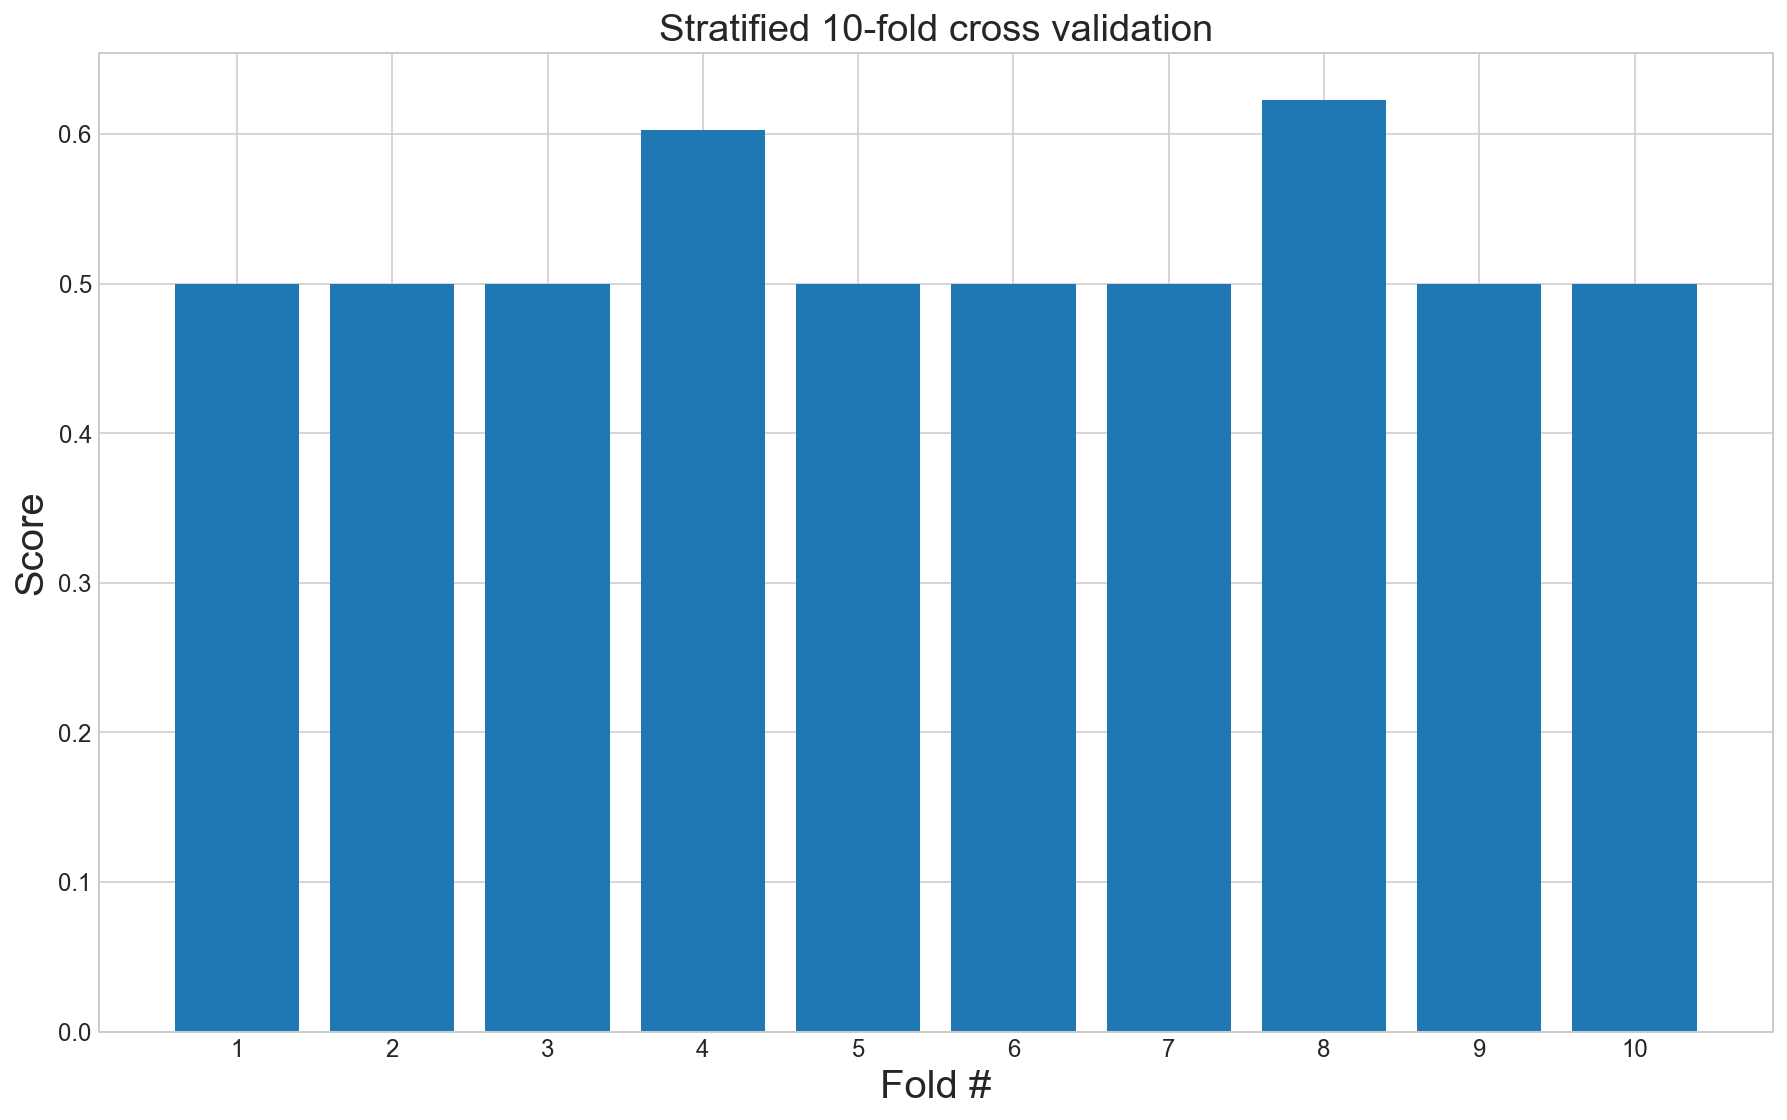

In [13]:
ax = plt.bar(range(len(scores)),scores)
plt.xticks(range(10),range(1,11))
plt.title('Stratified 10-fold cross validation')
plt.xlabel('Fold #')
plt.ylabel('Score')

print(
    '\n','='*50,'Accuracy (ROC): %0.2f (±%0.2f)' % (np.asarray(scores).mean(), np.asarray(scores).std() * 2),
    '='*50,'\n',sep='\n'
)

plt.show()